# Assignment 3

## Question 1

Show that the Gaussian kernel $k(x, x') = exp(-\|x-x'\|^2/2\sigma^2)$ can be expressed as the innner product of an infinite-dimensional feature space.

\begin{align*}
k(x,z) &= exp(-\frac{\|x-z\|^2}{2\sigma^2}) \\
&= exp(-\frac{x^Tx}{2\sigma^2}) exp(-\frac{z^Tz}{2 \sigma^2}) exp(\frac{x^Tz}{\sigma^2}) \\
&= exp(-\frac{x^Tx}{2\sigma^2}) exp(-\frac{z^Tz}{2 \sigma^2}) \sum_{j=0}^\infty \frac{1}{j!}(\frac{x^Tz}{\sigma^2})^2 \\
&= exp(-\frac{x^Tx}{2\sigma^2}) exp(-\frac{z^Tz}{2 \sigma^2}) [\sum_{j=0}^\infty \frac{1}[\sigma^{2j}j!] \sum_{i_1=0}^j ... \sum_{i_j=0}^j (x_{i1}...x_{i_j})(z_{i_1}...z_{i_j})] \\
&= \sum_{j=0}^\infty [\frac{(x_{i1}...x_{i_j})}{\sigma^{j}\sqrt{j!}}exp(-\frac{x^Tx}{2\sigma^2})][\frac{(z_{i_1}...z_{i_j})}{\sigma^{j}\sqrt{j!}}exp(-\frac{z^Tz}{2 \sigma^2})]
\end{align*}

where $\sum_{j=0}^\infty \frac{1}{\sigma^{2j}j!} \sum_{i_1=0}^j ...\sum_{i_j=0}^{j}(s_{i_1}...s_{i_j}) = 1$ if $j=0$. Therefore, computing the Gaussian kernel is the equivalent t taking the inner product after mapping the input to an infinite dimensional feature space, where each element of the mapping $\phi(x)$ has the form

$$ \frac{(x_{i_1} ... x_{i_j})}{\sigma^j \sqrt{j!}}exp(-\frac{x^Tx}{2\sigma^2}) $$


## Question 2

In [47]:
# Scientific and vector computation for python
import numpy as np

# Data Manipulation Library
import pandas as pd

# Pytorch Library
import torch

# Neural Network Module
import torch.nn as nn

# Plotting library
from matplotlib import pyplot

# inline graphs
%matplotlib inline

# Optimization module in scipy
from scipy import optimize

# import KFold library for splitting dataset
from sklearn.model_selection import KFold

# data url
github_url = 'https://raw.githubusercontent.com/RohanK99/machine-learning/master/CS480/A3/nonlinear-regression-dataset/'

In [48]:
# read training data
training_data = []
training_labels = []
for i in range(10):
    # training data
    url = github_url + 'trainInput{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_data.append(data)
    # training labels
    url = github_url + 'trainTarget{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_labels.append(data)

# concatenate data into 1 large data set and convert to numpy
X = (pd.concat(training_data)).to_numpy()
X = np.c_[np.ones(X.shape[0]), X] # add column of ones
y = ((pd.concat(training_labels)).to_numpy())[:,0] # first column

In [49]:
# read test data
data_url = github_url + 'testInput.csv'
label_url = github_url + 'testTarget.csv'
data = pd.read_csv(data_url, header=None)
t_X = data.to_numpy()
t_X = np.c_[np.ones(t_X.shape[0]), t_X] # add column of ones
labels = pd.read_csv(label_url, header=None)
t_y = labels.to_numpy()[:,0]

a) Regularized generalized linear regression: perform least square regression with the penalty term $0.5w^Tw$. Use monomial basis functions up to degree $d: \{\prod_{i}(x_i)^{n_i} | \sum_{i}n_i \leq d\}$. A monomial of degree less than or equal to $d$ is a product of variables (e.g. $\prod_{i}(x_i)^{n_i}$) where the sum of their exponents is less than or equal to $d$ (e.g. $\sum_{i}{n_i} \leq d$)

Recall that the linear regression model can be expressed with hypothesis:

$$ h_w(x) = w^Tx = w_0 + w_1 x_1 $$

where the minimization problem is

$$ w^* = argmin_w \frac{1}{2}\sum_{n=1}^{N} (t_n - w^T \overline{x}_n)^2 + \frac{\lambda}{2}|w|_2^2$$

Now for non-linear data we need a generalized linear regression minimization problem. To convert a non-linear problem into a linear one we can apply a basis function to $\overline{x}$. A basis function is a mapping from one vector space to another in which the data is linear.

The polynomial basis function that will be used in the question is $\phi_{j}(x) = x^j$

The hypothesis can now be expressed as
$$ h_w(x) = w_0\phi_0(x) + w_1\phi_1(x) + w_2\phi_2(x) $$

For 2 features our hypothesis up to degree $3$ will look like

$$ h_w(x) = w_0 + w_1x_1 + w_2x_2 + w_3x_1^2 + w_4x_2^2 + w_5x_1^2x_2 + w_6x_1x_2^2 + w_7x_1^2x_2^2 + w_8x_1^3 + w_9x_2^3 $$

We can now extrapolate this hypothesis for any degree $d$.

Applying this to get a genearlized equation for linear regression we get:

$$ w^* = argmin_w \frac{1}{2}\sum_{n=1}^{N} (t_n - w^T \phi(\overline{x}_n))^2 + \frac{\lambda}{2}|w|_2^2$$

Solving for the closed form solution we get.

$$ w^* = (B^TB + \lambda I)^{-1} B^Ty $$

where $B$ is the data after that basis function is applied to $X$.

Note: For this problem we assume $\lambda = 1$

In [50]:
def linear_regression(X, y, lambda_):
  # using regularized closed form solution to return theta (weights)
  # theta = inverse(Lambda*IdentityMatrix+X'*X)*X'*y
  A = np.transpose(X)@X
  b = np.transpose(X)@y
  weights = np.linalg.pinv(lambda_ * np.eye(A.shape[0]) + A)@b
  return weights

In [51]:
def mean_squared_error(X, y, weights):
    predicted = X@weights
    squared_error = np.square(predicted - y)
    return np.mean(squared_error)

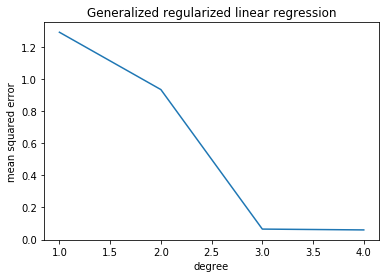

In [52]:
kf = KFold(n_splits=10)
max_degree = 5
lambda_ = 1

mean_squared_errors = [0] * max_degree
for train, test in kf.split(X):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]

    # degree 1
    weights = linear_regression(X_train, y_train, lambda_)
    mean_squared_errors[1] += mean_squared_error(X_test, y_test, weights)

    for d in range(2, max_degree): # degree 2 to 4
        for j in range(d+1): # monomial basis function is applied
            X_train = np.append(X_train, ((X[train][:,1] ** (j)) * (X[train][:,2] ** (d-j))).reshape(X[train].shape[0], 1), axis=1)
            X_test = np.append(X_test, ((X[test][:,1] ** (j)) * (X[test][:,2] ** (d-j))).reshape(X[test].shape[0], 1), axis=1)

        weights = linear_regression(X_train, y_train, lambda_)
        mean_squared_errors[d] += mean_squared_error(X_test, y_test, weights)

mean_squared_errors = [error / 10 for error in mean_squared_errors] # divide by 10 since 10-fold cross validation

pyplot.plot(range(1,max_degree), mean_squared_errors[1:], '-')
pyplot.xlabel("degree")
pyplot.ylabel("mean squared error")
pyplot.title("Generalized regularized linear regression")
pyplot.show()

From this we see that degree 3 provides us the most minimized error and we can apply this to our test dataset

In [53]:
X_train = X
X_test = t_X

# dataset into monomial of degree 3
for d in range(2, 4):
    for j in range(d+1):
        X_train = np.append(X_train, ((X_train[:,1] ** (j)) * (X_train[:,2] ** (d-j))).reshape(X_train.shape[0], 1), axis=1)
        X_test = np.append(X_test, ((X_test[:,1] ** (j)) * (X_test[:,2] ** (d-j))).reshape(X_test.shape[0], 1), axis=1)

weights = linear_regression(X_train, y, 1)

print("Test set mean squared error: " + str(mean_squared_error(X_test, t_y, weights)))

Test set mean squared error: 0.06366132035168122


b) Bayesian Generalized Linear Regression

The linear regression problem can be reformulated by assuming part of $y$ to be set from gaussian distribution $\varepsilon \sim N(0, \sigma^2)$ as follows:

$$ y = w^T \phi(x) + \varepsilon $$

where $\phi(x)$ is a fixed set of basis functions (i.e. $\phi(x) = [\phi_1(x), \phi_2(x), ..., \phi_m(x)]$)

The goal of Bayesian linear regression is not to find the best model parameter $w$, but rather to find a model parameter's posterior distribution as follows: 

\begin{align*}
P(w|y, X) &= \frac{P(y|w, X)P(w|X)}{P(y|x)} \\
&= ke^{-\frac{1}{2}(w-\overline{w})^TA(w-\overline{w})} \\
&= N(\overline{w}, A^{-1})
\end{align*}

where

\begin{align*}
\overline{w} &= \sigma^{-2}A^{-1}\overline{X}y \\
A &= \sigma^{-2}\overline{X}\overline{X}^T + \Sigma^{-1} 
\end{align*}



In [54]:
def bayesian_regression(X, y):
    A = (X@X.T) + np.linalg.pinv(np.identity(X.shape[0]))
    w = y@np.linalg.pinv(A)@X
    return w.T

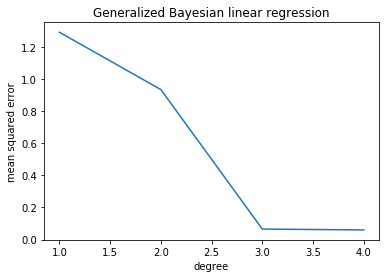

In [55]:
kf = KFold(n_splits=10)
max_degree = 5

mean_squared_errors = [0] * max_degree
for train, test in kf.split(X):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]

    # degree 1
    weights = bayesian_regression(X_train, y_train)
    mean_squared_errors[1] += mean_squared_error(X_test, y_test, weights)

    for d in range(2, max_degree): # degree 2 to 4
        for j in range(d+1): # monomial basis function is applied
            X_train = np.append(X_train, ((X[train][:,1] ** (j)) * (X[train][:,2] ** (d-j))).reshape(X[train].shape[0], 1), axis=1)
            X_test = np.append(X_test, ((X[test][:,1] ** (j)) * (X[test][:,2] ** (d-j))).reshape(X[test].shape[0], 1), axis=1)

        weights = bayesian_regression(X_train, y_train)
        mean_squared_errors[d] += mean_squared_error(X_test, y_test, weights)

mean_squared_errors = [error / 10 for error in mean_squared_errors] # divide by 10 since 10-fold cross validation

pyplot.plot(range(1,max_degree), mean_squared_errors[1:], '-')
pyplot.xlabel("degree")
pyplot.ylabel("mean squared error")
pyplot.title("Generalized Bayesian linear regression")
pyplot.show()

In [56]:
X_train = X
X_test = t_X

# dataset into monomial of degree 3
for d in range(2, 4):
    for j in range(d+1):
        X_train = np.append(X_train, ((X_train[:,1] ** (j)) * (X_train[:,2] ** (d-j))).reshape(X_train.shape[0], 1), axis=1)
        X_test = np.append(X_test, ((X_test[:,1] ** (j)) * (X_test[:,2] ** (d-j))).reshape(X_test.shape[0], 1), axis=1)

weights = bayesian_regression(X_train, y)

print("Test set mean squared error: " + str(mean_squared_error(X_test, t_y, weights)))

Test set mean squared error: 0.06366132887332042


c) Gaussian Process Regression

Gaussian process regression: assume the output noise is Gaussian with variance = 1. Use the following kernels:
* Identity: $k(x, x') = x^Tx'$
* Gaussian: $k(x, x') = e^{-\|x - x'\|^2/2\sigma^2}$
* Polynomial: $k(x, x') = (x^Tx' + 1)^d$

Extending from Bayesian Linear Regression we can convert the complexity of the problem from the being cubic in the number of basis functions to being cubic in the number of training points by trying to learn the function rather than the weights.

We can compute the prediction using Gaussian process regression through the following:

In general, the posterior predictive distribution is
$$ P(y_*|X,x_*) = \int_{w} P(y_*,w|X,x_*)dw = \int_{w}P(y_*|w,x_*,X)P(w|X)dw $$

This is intractable in closed form. For the special case of having Guassian likelihood and prior the expression is Gaussian and the mean and covariance can be derived as such.

Prior: $$P(f(\cdot)) = N(m(\cdot),k(\cdot,\cdot))$$
Likelihood: $$P(y|X,f) = N(f(\cdot), \sigma^2I)$$
Posterior: $$P(f(\cdot)|X,y) = N(\overline{f}(\cdot), k'(\cdot, \cdot))$$
where $$\overline{f}(\cdot) = k(\cdot,X)(K+\sigma^2I)^{-1}y$$
and $$k'(\cdot,\cdot)=k(\cdot,\cdot)-k(\cdot,X)(K+\sigma^2I)^{-1}k(X,\cdot)$$

We can then predict with:
$$P(y_*|x_*, X, y) = N(\overline{f}(x_*), k'(x_*, x_*))$$

In [57]:
def identity_kernel(X1, X2, unused_param=1.0):
    return (X1.dot(X2.T))

In [58]:
def gaussian_kernel(X1, X2, sigma=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return np.exp(-0.5 / sigma**2 * sqdist)

In [59]:
def polynomial_kernel(X1, X2, degree=1.0):
    return (X1.dot(X2.T)+1)**degree

In [60]:
def posterior_prediction(kernel, X_s, X_train, y_train, hyper_param=1.0, sigma_y=1.0):
    K = kernel(X_train, X_train, hyper_param) + sigma_y**2 + np.eye(len(X_train))
    K_s = kernel(X_train, X_s, hyper_param)
    K_ss = kernel(X_s, X_s, hyper_param)
    K_inv = np.linalg.pinv(K)

    mu_s = K_s.T.dot(K_inv).dot(y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

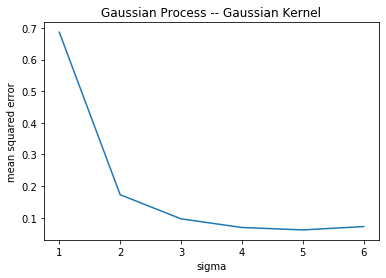

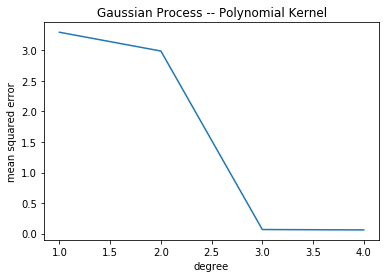

In [61]:
kf = KFold(n_splits=10)
max_sigma = 6
max_degree = 4

rbf_mean_squared_errors = [0] * (max_sigma + 1)
poly_mean_squared_errors = [0] * (max_degree + 1)
for train, test in kf.split(X):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]

    for i in range(1, max_sigma+1):
        mu, cov = posterior_prediction(gaussian_kernel, X_test, X_train, y_train, i)
        rbf_mean_squared_errors[i] += np.mean(np.square(mu - y_test))

    for i in range(1, max_degree+1):
        mu, cov = posterior_prediction(polynomial_kernel, X_test, X_train, y_train, i)
        poly_mean_squared_errors[i] += np.mean(np.square(mu - y_test))

rbf_mean_squared_errors = [error / 10 for error in rbf_mean_squared_errors]
poly_mean_squared_errors = [error / 10 for error in poly_mean_squared_errors]

pyplot.plot(range(1,max_sigma+1), rbf_mean_squared_errors[1:], '-')
pyplot.xlabel("sigma")
pyplot.ylabel("mean squared error")
pyplot.title("Gaussian Process -- Gaussian Kernel")
pyplot.show()

pyplot.plot(range(1,max_degree+1), poly_mean_squared_errors[1:], '-')
pyplot.xlabel("degree")
pyplot.ylabel("mean squared error")
pyplot.title("Gaussian Process -- Polynomial Kernel")
pyplot.show()

We can see that the mean squared error is minimized at sigma = 5 and degree = 4 for gaussian and polynomial regression respectively. Using these hyperparameters to train the full training set and testing on the test set yields the following results

In [62]:
mu, cov = posterior_prediction(identity_kernel, t_X, X, y, 1)
print("identity kernel mean squared error: " + str(np.mean(np.square(mu - t_y))))

mu, cov = posterior_prediction(gaussian_kernel, t_X, X, y, 5)
print("gaussian kernel mean squared error: " + str(np.mean(np.square(mu - t_y))))

mu, cov = posterior_prediction(polynomial_kernel, t_X, X, y, 4)
print("polynomial kernel mean squared error: " + str(np.mean(np.square(mu - t_y))))

identity kernel mean squared error: 5.361424031957728
gaussian kernel mean squared error: 0.04968810197881765
polynomial kernel mean squared error: 0.05984121476131743


d) Neural Network: Minimize the squared loss of a two-layer neural network with a sigmoid activation function for the hidden nodes and the identity function for the output node.

The basis behind this neural network is to find a set of weights between nodes that when linearly combined result in the output. The hidden layer performs a linear combination of the incoming features and applies a sigmoid to it. The output is the identity function of the hidden layer.

To train the model we use a Stochasitc Gradient Descent optimizer and backpropagation based on mean squared error loss function. We predict based on the current weights then calculate the loss function and backprogate the error to adjust the weights.

In [19]:
class Neural_Network(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Neural_Network, self).__init__()
        self.hidden = nn.Linear(n_feature, n_hidden)
        self.predict = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.predict(x)
        return x

In [45]:
def trainNN(net, X, y):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    loss_func = nn.MSELoss() # Mean Squared Error Loss

    for t in range(60000):
        prediction = net(X)              # input x and predict based on x

        loss = loss_func(prediction, y)  # must be (1. nn output, 2. target)

        optimizer.zero_grad()            # clear gradients for next train
        loss.backward()                  # backpropagation, compute gradients
        optimizer.step()                 # apply gradients

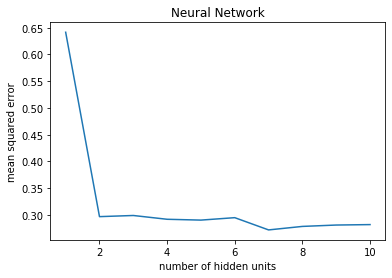

In [44]:
kf = KFold(n_splits=10)
max_hidden_nodes = 10
loss_func = nn.MSELoss() # Mean Squared Error Loss

mean_squared_errors = [0] * (max_hidden_nodes + 1)
for train, test in kf.split(X):
    X_train = torch.from_numpy(X[train]).float()
    y_train = torch.from_numpy(y[train]).float().reshape(y[train].shape[0], 1)
    X_test = torch.from_numpy(X[test]).float()
    y_test = torch.from_numpy(y[test]).float().reshape(y[test].shape[0], 1)

    for i in range(1, max_hidden_nodes+1):
        net = Neural_Network(n_feature=3, n_hidden=i, n_output=1)
        trainNN(net, X_train, y_train)
        mean_squared_errors[i] += loss_func(net(X_test), y_test).data.numpy()

mean_squared_errors = [error / 10 for error in mean_squared_errors]

pyplot.plot(range(1,max_hidden_nodes+1), mean_squared_errors[1:], '-')
pyplot.xlabel("number of hidden units")
pyplot.ylabel("mean squared error")
pyplot.title("Neural Network")
pyplot.show()

From this we can see that 10 hidden units minimizes the mean squared error. We will now generate a Neural Network with 10 hidden layers to predict our test set

In [46]:
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(y).float().reshape(y.shape[0], 1)

X_test = torch.from_numpy(t_X).float()
y_test = torch.from_numpy(t_y).float().reshape(t_y.shape[0], 1)

net = Neural_Network(n_feature=3, n_hidden=10, n_output=1)
trainNN(net, X_train, y_train)

prediction = net(X_test)
loss = loss_func(net(X_test), y_test).data.numpy()
print("Neural Network MSE: " + str(loss))

Neural Network MSE: 0.032255564
